In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

set seed for reproducibly and load dataset.

In [2]:
tf.random.set_seed(271)
data = pd.read_csv("spotprices.csv", index_col=0)
data = data.dropna()

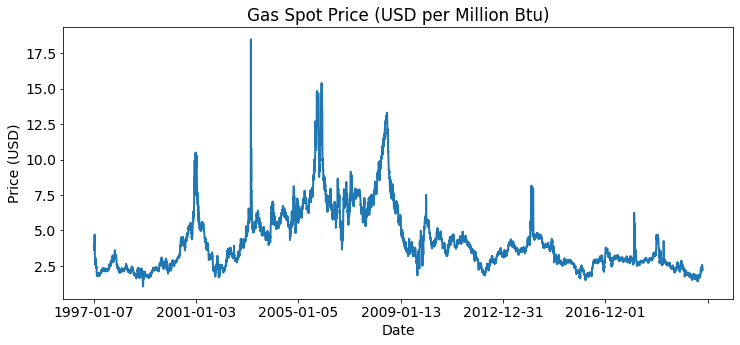

In [3]:
plt.rcParams["figure.figsize"] = [12, 5]
plt.rcParams.update({'font.size': 14})
ax = data["Price"].plot(lw=2)
text = ax.set(xlabel="Date", ylabel="Price (USD)", 
              title="Gas Spot Price (USD per Million Btu)")

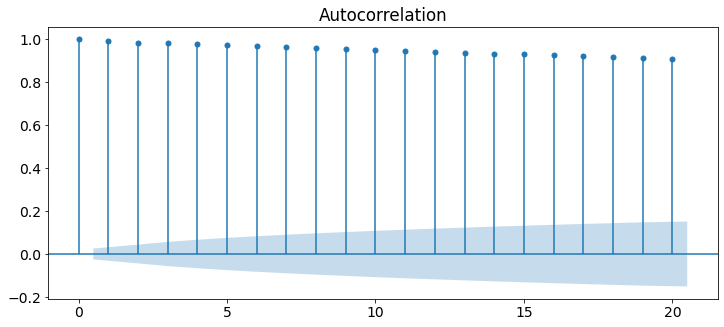

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data, alpha=0.05, lags=20)
plt.show()

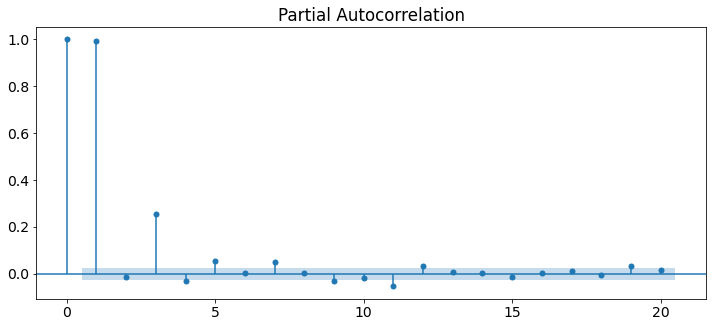

In [5]:
plot_pacf(data, alpha=0.05, lags=20)
plt.show()

The split_sequence funcion works by breaking the data up with n_steps predictors. That is, we need n_steps to make a prediction. Similar to lag in time series analysis. The report uses 5 and 1 lags.

In [6]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    n = len(sequence)
    for i in range(n):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

spot_prices = data["Price"].values
X, y = split_sequence(spot_prices, 5)
df = pd.DataFrame(X)
df.columns = ["x1", "x2", "x3", "x4", "x5"]
df["y"] = y
df = df.dropna()
df

,x1,x2,x3,x4,x5,y
0,3.82,3.80,3.61,3.92,4.00,4.01
1,3.80,3.61,3.92,4.00,4.01,4.34
2,3.61,3.92,4.00,4.01,4.34,4.71
3,3.92,4.00,4.01,4.34,4.71,3.91
4,4.00,4.01,4.34,4.71,3.91,3.26
...,...,...,...,...,...,...
5942,2.43,2.35,2.39,2.57,2.54,2.52
5943,2.35,2.39,2.57,2.54,2.52,2.52
5944,2.39,2.57,2.54,2.52,2.52,2.46
5945,2.57,2.54,2.52,2.52,2.46,2.30


Split our data into a training which will contain $80\%$ of our data and testing set will contain the last $20%$. We split our predictors and response.

In [7]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("y")
test_labels = test_features.pop("y")

# The code below is only nneded when the lag is 1
# train_features = train_features.squeeze()
# test_features = test_features.squeeze()

Normlize the training features.

In [8]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))

The input and the single hidden layer uses 50 neurons with the ReLU activation function. Also, 
uses dropout for regularization.

In [9]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(50, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(50, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1)
    ])
    
    model.compile(loss="mean_absolute_error",
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

mlp = build_and_compile_model(normalizer)
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense (Dense)                (None, 50)                300       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,912
Trainable params: 2,901
Non-trainable params: 11
_____________________________________________________

Fit the model with 100 epochs and a validation of $20\%$

In [10]:
%%time
history = mlp.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 38 s, sys: 5.01 s, total: 43 s
Wall time: 37.3 s


The figure below visualizes the model's training progress.

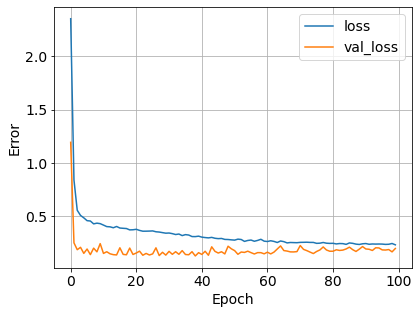

In [11]:
def plot_loss(history):
    plt.rcParams["figure.figsize"] = [6.4, 4.8]
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)

plot_loss(history)

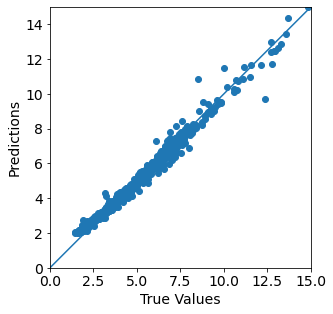

In [12]:
test_predictions = mlp.predict(test_features).flatten()
plt.rcParams["figure.figsize"] = [6.4, 4.8]
a = plt.axes(aspect="equal")
plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims = [0, 15]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

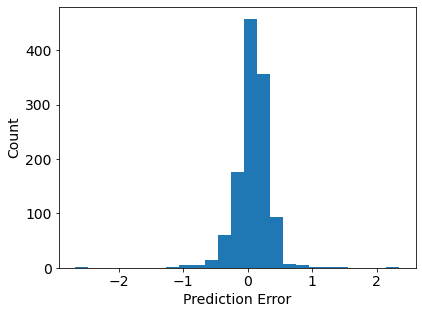

In [13]:
error = test_predictions - test_labels
plt.rcParams["figure.figsize"] = [6.4, 4.8]
plt.hist(error, bins=25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

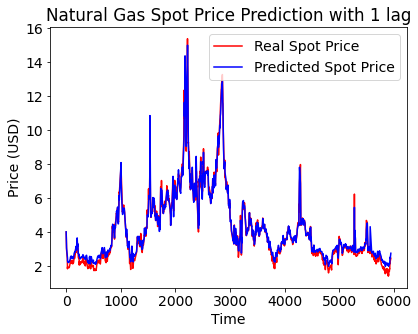

In [14]:
plt.plot(test_labels.index,test_labels.values, color = 'red', label = 'Real Spot Price')
plt.plot(test_labels.index,test_predictions, color = 'blue', label = 'Predicted Spot Price')
plt.title('Natural Gas Spot Price Prediction with 1 lag')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [15]:
results = {}
results["Train MSE"] = [mlp.evaluate(train_features, train_labels, verbose=0)]
results["Test MSE"] = [mlp.evaluate(test_features, test_labels, verbose=0)]
pd.DataFrame(results)

,Train MSE,Test MSE
0,0.199808,0.192677


 Making a prediction

In [16]:
#values use to predict
z = test_features.tail(1).values
z

array([[2.39, 2.57, 2.54, 2.52, 2.52]])

In [17]:
#real value
test_labels.tail(1)

5944    2.46
Name: y, dtype: float64

In [18]:
#prediction `value
mlp.predict(z, verbose=0)

array([[2.7573462]], dtype=float32)